# Reference bias using expected vs observed # of bases with no coverage

* https://www.illumina.com/documents/products/technotes/technote_coverage_calculation.pdf
* https://en.wikipedia.org/wiki/DNA_sequencing_theory#Early_uses_derived_from_elementary_probability_theory
* http://seqanswers.com/forums/showpost.php?p=161353&postcount=2

The problem can be boiled down to the following question: given sequence coverage $X$, the proportion of sites with no coverage can be modelled as $Poisson(\lambda = 0)$. Under ideal conditions and infinite number of sites, the empirical counts of sites with no coverage should be exactly equal to this value.

What is the proportion of sites with no coverage in our samples? Are there some worrying differences between Neanderthal and Denisovan samples? Keep in mind that both _Denisova 4_ and _Denisova 8_ have almost the same TMRCA, significantly different from all other Neanderthals, who also give the same values between each other.

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(glue)
library(here)
library(rtracklayer); library(GenomicRanges)
})

devtools::load_all(".")

Loading ychr


In [2]:
cov_df <- readRDS(here("data/rds/cov_df.rds"))

In [3]:
samples <- unique(cov_df$name)

In [4]:
samples

[1] "Denisova 4"              "Denisova 8"             
 [3] "Spy 1"                   "Mezmaiskaya 2"          
 [5] "El Sidrón 1253 (118 kb)" "El Sidrón 1253"         
 [7] "A00"                     "S_BedouinB-1"           
 [9] "S_Burmese-1"             "S_Dai-2"                
[11] "S_Finnish-2"             "S_French-1"             
[13] "S_Han-2"                 "S_Ju_hoan_North-1"      
[15] "S_Karitiana-1"           "S_Papuan-2"             
[17] "S_Punjabi-1"             "S_Saami-2"              
[19] "S_Sardinian-1"           "S_Thai-1"               
[21] "S_Turkish-1"             "mez2_dp1"               
[23] "mez2_dp10"               "mez2_dp2"               
[25] "mez2_dp3"                "mez2_dp4"               
[27] "mez2_dp5"                "mez2_dp6"               
[29] "mez2_dp7"                "mez2_dp8"               
[31] "mez2_dp9"                "Mezmaiskaya 2 (shotgun)"
[33] "Spy 1 (shotgun)"

In [5]:
avg_cov <- cov_df %>%
    group_by(name) %>%
    summarise(avg_coverage = mean(coverage)) %>%
    filter(!str_detect(name, "1253")) %>%
    arrange(avg_coverage)

In [6]:
avg_cov <- avg_cov %>%
    mutate(observed_zero = round(map_dbl(name, ~ mean(filter(cov_df, name == .x)$coverage == 0)), 5),
           expected_zero = round(dpois(x = 0, lambda = avg_coverage), 5),
           difference = abs(observed_zero - expected_zero)) %>%
    arrange(-difference)

In [7]:
avg_cov %>% filter(!str_detect(name, "mez2_dp"))

name,avg_coverage,observed_zero,expected_zero,difference
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Denisova 8,3.4819494,0.09557,0.03075,0.06482
Spy 1,0.8253635,0.49341,0.43808,0.05533
Denisova 4,1.5451500,0.26566,0.21328,0.05238
Mezmaiskaya 2,14.2548400,0.03584,0.00000,0.03584
Spy 1 (shotgun),0.4584791,0.62488,0.63224,0.00736
Mezmaiskaya 2 (shotgun),0.8248668,0.44175,0.43829,0.00346
A00,20.8671570,0.00050,0.00000,0.00050
S_Papuan-2,23.0649329,0.00049,0.00000,0.00049
S_Saami-2,22.6298167,0.00033,0.00000,0.00033


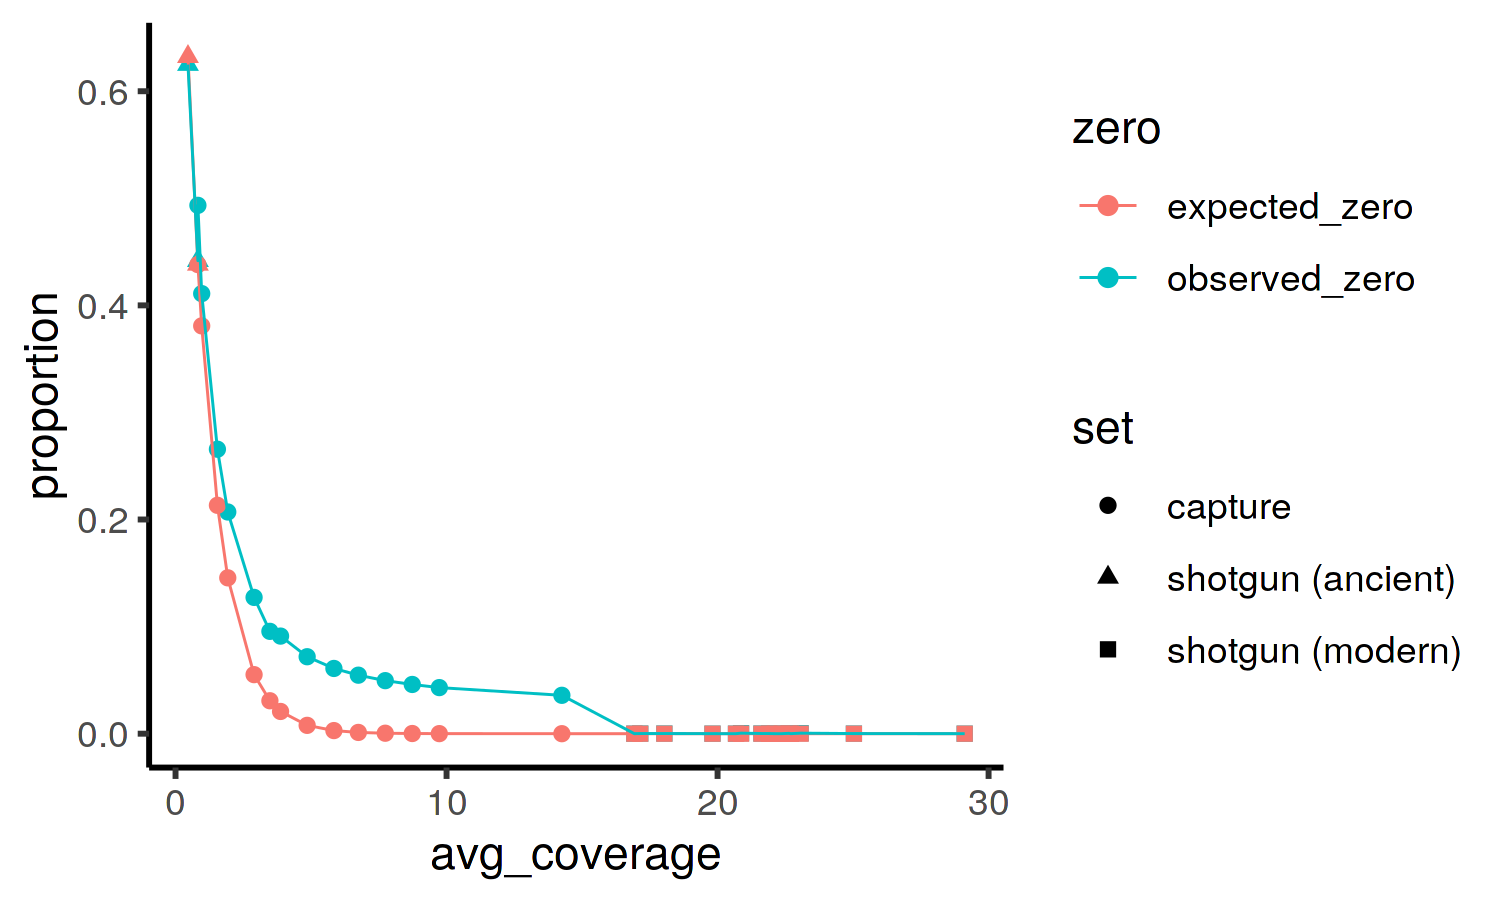

In [8]:
set_dim(5, 3)

avg_cov %>%
gather(zero, proportion, -name, -avg_coverage, -difference) %>%
mutate(set = case_when(
    str_detect(name, "S_") ~ "shotgun (modern)",
    name == "A00" ~ "shotgun (modern)",
    str_detect(name, "shotgun") ~ "shotgun (ancient)",
    TRUE ~ "capture"
)) %>%
ggplot(aes(avg_coverage, proportion, color = zero)) +
    geom_point(aes(shape = set)) +
    geom_line(aes(group = zero), size = 1/4) +
    theme_classic()